# Randomized Optimization
1. Randomized hill climbing
2. Simulated annealing
3. Genetic algorithm
4. MIMIC

## Import packages

In [116]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
import matplotlib.pyplot as plt
import numpy as np

## Define Three problems
1. Sharp Global Peak
2. Wide Basin Global Peak
3. Travelling Salesman Problem (TSP)

In [117]:
def plot_fitness_function(fitness_func):
    x = list(range(1000))
    y = [fitness_func(i) for i in x]
    plt.plot(x, y)
    plt.title('Fitness function')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

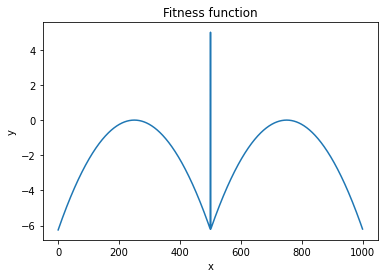

In [118]:
# Sharp Global Peak
def f1(x):
    assert 0 <= x < 1000
    if 0 <= x < 500:
        return - (x - 250) ** 2 / 10000
    elif x == 500:
        return 5
    else:
        return - (x - 750) ** 2 / 10000
    
plot_fitness_function(f1)

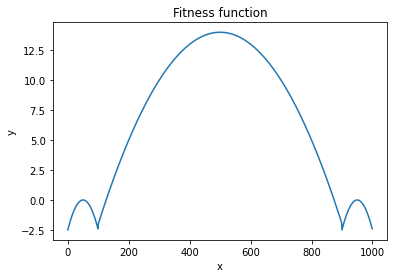

In [119]:
# Wide Basin Global Peak
def f2(x):
    assert 0 <= x < 1000
    if 0 <= x < 100:
        return - (x - 50) ** 2 / 1000
    elif x < 900:
        return 14 - (x - 500) ** 2 / 10000
    else:
        return - (x - 950) ** 2 / 1000
    
plot_fitness_function(f2)

## Apply each algorithm on each problem

In [120]:
def plot_fitness_curve(fitness_curve):
    iters = list(range(1, len(fitness_curve) + 1))
    plt.plot(iters, fitness_curve)
    plt.title('Fitness curve')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness')
    plt.show()

In [121]:
def simulated_annealing(fitness_func):
    fitness = mlrose.CustomFitness(fitness_func)
    problem = mlrose.DiscreteOpt(length=1, fitness_fn=fitness, maximize=True, max_val=1000)
    best_state, best_fitness, fitness_curve = mlrose.simulated_annealing(
        problem,
        schedule=mlrose.ExpDecay(),
        max_attempts=10,
        max_iters=1000,
        init_state =np.array([0]),
        random_state=1,
        curve=True,
    )
    print('Best solution = {}'.format(best_state[0]))
    print('Best fitness corresponding to best solution = {}'.format(best_fitness[0]))
    plot_fitness_curve(fitness_curve)

In [122]:
def randomized_optimization(fitness_func, algorithm):
    if algorithm == 'simulated-annealing':
        simulated_annealing(fitness_func)
    else:
        raise ValueError('Algorithm {} is not supported!'.format(algoritm))

-------------------------------------------------------------
Result for algorithm simulated-annealing applied on problem 1
-------------------------------------------------------------
Best solution = 728
Best fitness corresponding to best solution = -0.0484


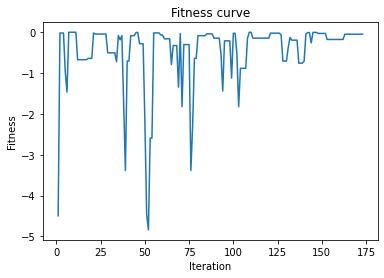

-------------------------------------------------------------
Result for algorithm simulated-annealing applied on problem 2
-------------------------------------------------------------
Best solution = 490
Best fitness corresponding to best solution = 13.99


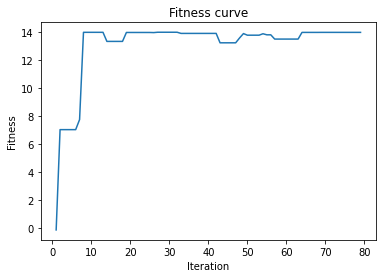

In [123]:
fitness_funcs = [f1, f2]
algorithms = ['simulated-annealing']
for i, fitness_func in enumerate(fitness_funcs):
    for algorithm in algorithms:
        print('-------------------------------------------------------------')
        print('Result for algorithm {0} applied on problem {1}'.format(algorithm, i + 1))
        print('-------------------------------------------------------------')
        randomized_optimization(fitness_func, algorithm)